In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from tqdm import trange

In [2]:
from matplotlib.image import imread
import os
import numpy as np
from random import randrange

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
!unzip cats_512.zip

Archive:  cats_512.zip
  inflating: cats_512.npy            


In [7]:
with open("cats_512.npy", "rb") as f:
    data = np.load(f)/256
data = torch.Tensor(data).movedim(3,1)
ds = TensorDataset(data)
dl = DataLoader(ds, batch_size=64, shuffle=True)
data.shape

torch.Size([512, 3, 64, 64])

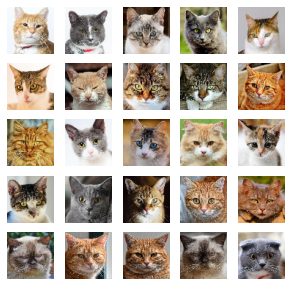

In [8]:
n_rows, n_cols, i = 5, 5, 1
plt.figure(figsize=(n_cols, n_rows))
for im in data[:n_rows*n_cols].movedim(1, 3):
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(im)
    #plt.title(i-1)
    plt.axis('off')
    i += 1

In [19]:
def ConvBlock(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

def ConvTransBlock(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

def Generator(latent_dim, features=8):  # input: latent_dim, 1, 1
    return nn.Sequential(
        ConvTransBlock(latent_dim, 8*features, 4, 1, 0),   # 8f, 4, 4
        ConvTransBlock(8*features, 4*features, 4, 2, 1),   # 4f, 8, 8
        ConvTransBlock(4*features, 2*features, 4, 2, 1),    # 2f, 16, 16
        ConvTransBlock(2*features, features, 4, 2, 1),    # f, 32, 32
        nn.ConvTranspose2d(features, 3, 4, 2, 1),           # 3, 64, 64
        nn.Sigmoid()
    )

def Discriminator(features=8):  # input: 3, 64, 64
    return nn.Sequential(
        ConvBlock(3, features, 4, 2, 1),    # f, 32, 32
        ConvBlock(features, 2*features, 4, 2, 1),    # 2f, 16, 16
        ConvBlock(2*features, 4*features, 4, 2, 1),    # 4f, 8, 8
        ConvBlock(4*features, 8*features, 4, 2, 1),    # 8f, 4, 4
        nn.Conv2d(8*features, 1, 4),   # 1, 1, 1
        nn.Sigmoid()
    )

In [62]:
latent_dim = 100
features = 50
gen = Generator(latent_dim, features).to(device)
dis = Discriminator(features).to(device)

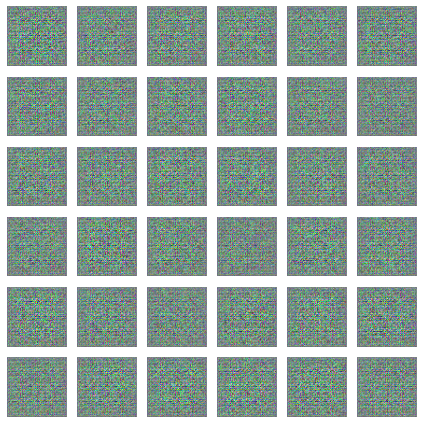

In [63]:
fixed_noise=torch.randn(36, latent_dim, 1, 1).to(device)
def test_gen(noise):
    with torch.no_grad():
        fake = gen(noise).detach().cpu()
    return fake

def test_plot():
    fake=test_gen(fixed_noise).movedim(1, 3)
    fig, axs = plt.subplots(6,6, figsize=(6,6))
    for ax, im in zip(axs.flatten(), fake):
        ax.imshow(im)
        ax.axis('off')
    fig.tight_layout()
test_plot()

In [64]:
loss_fn = nn.BCELoss()

learning_rate = 3e-4
gen_opt = torch.optim.AdamW(gen.parameters(), lr = learning_rate, betas=(0.5, 0.999))
dis_opt = torch.optim.AdamW(dis.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [65]:
def train_loop():
    size = len(dl.dataset)
    total_gen_loss = 0
    total_dis_loss = 0

    for x, in dl:
        real = x.to(device)
        dis.zero_grad()
        real_output = dis(real).view(-1)
        dis_real_loss = loss_fn(real_output, torch.ones_like(real_output))
        dis_real_loss.backward()

        noise = torch.randn(x.shape[0], latent_dim, 1, 1).to(device)
        fake = gen(noise)
        fake_output = dis(fake.detach()).view(-1)
        dis_fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output))
        dis_fake_loss.backward()

        dis_opt.step()

        gen.zero_grad()
        output = dis(fake).view(-1)
        gen_loss = loss_fn(output, torch.ones_like(output))
        gen_loss.backward()
        gen_opt.step()

        dis_loss = dis_real_loss+dis_fake_loss

        total_dis_loss += dis_loss.item()
        total_gen_loss += gen_loss.item()

    return total_gen_loss/size, total_dis_loss/size


In [66]:
history_g=[]
history_d=[]

100%|██████████| 200/200 [01:51<00:00,  1.79it/s, DisL=0.0137, GenL=0.123]


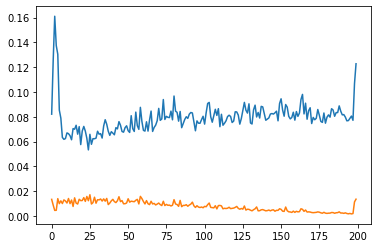

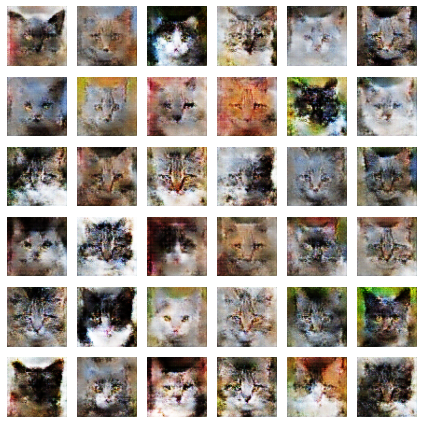

In [67]:
epochs = 200
loop = trange(epochs)
for epoch in loop:
    g_loss, d_loss = train_loop()   
    history_d.append(d_loss)
    history_g.append(g_loss)   
    loop.set_postfix(DisL=d_loss, GenL=g_loss)

plt.plot(history_g)
plt.plot(history_d)
test_plot()

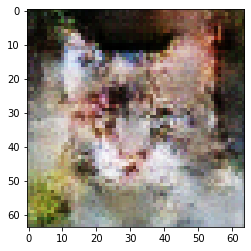

In [68]:
noise2=torch.randn(1, latent_dim, 1, 1).to(device)
plt.imshow(gen(noise2).detach().cpu()[0].movedim(0,2))

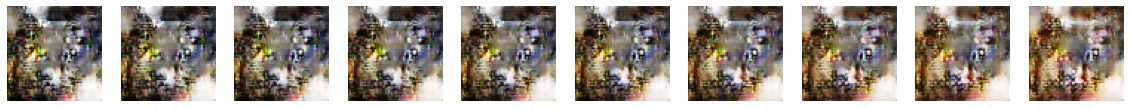

In [61]:
z1, z2 = torch.randn(2, latent_dim, 1, 1)
steps = 10
delta = (z2-z1)/steps
z = [z1 + i*delta for i in range(steps)]
z = torch.stack(z).to(device)

with torch.no_grad():
    fake = gen(z).detach().cpu()

fig, axs = plt.subplots(1, len(z), figsize=(2*len(z), 4))

for im, ax in zip(fake, axs):
    ax.imshow(im.movedim(0, 2))
    ax.axis("off")


In [ ]:
torch.save({
            'gen_state_dict': gen.state_dict(),
            'gen_opt_state_dict': gen_opt.state_dict(),
            'dis_state_dict': dis.state_dict(),
            'dis_opt_state_dict': dis_opt.state_dict()
            }, "gan_kotki_v1.pkl")

In [ ]:
checkpoint = torch.load("gan_kotki_v1.pkl")
gen.load_state_dict(checkpoint['gen_state_dict'])
gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
dis.load_state_dict(checkpoint['dis_state_dict'])
dis_opt.load_state_dict(checkpoint['dis_opt_state_dict'])
